<a href="https://colab.research.google.com/github/Kitnelly/Predicting-Through-The-Lens/blob/main/Collaborative_filtering_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content-Based and Collaborative Filtering

In [ ]:
import math
import io
import os
from google.colab import files
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd

In [ ]:
#Connecting the Collab to my google drive in order to access files there.

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

pathname = "/content/drive/My Drive/Capstone/movielens"
os.chdir(pathname)

Mounted at /content/drive


The MovieLens dataset was downloaded as 3 separate .dat files, so in order to convert the .dat file to a csv file we must replace all the separaters with commas.

In [ ]:
files = {
    "movies" : "movie_id,title,genres",
    "ratings": "user_id,movie_id,rating,ts",
    "users"  : "user_id,gender,age,occupation,zip"
}
DELIM = ","
for name in files:
  with open("%s.dat" % name, encoding="ISO-8859-1") as src:
    with open("%s.csv" % name, "w") as dst:
      headers = files[name] + "\n"
      data = src.read().replace(DELIM,"`").replace("::",DELIM)
      dst.write(headers + data)

In [ ]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
users = pd.read_csv('users.csv')

The following cells take a look at the information contained in our files in order to get a good grasp on data.

In [ ]:
# Check the top 5 rows
print(ratings.head(10))

   user_id  movie_id  rating         ts
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291
5        1      1197       3  978302268
6        1      1287       5  978302039
7        1      2804       5  978300719
8        1       594       4  978302268
9        1       919       4  978301368


In [ ]:
# Check the file info
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   user_id   1000209 non-null  int64
 1   movie_id  1000209 non-null  int64
 2   rating    1000209 non-null  int64
 3   ts        1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB
None


In [ ]:
# Check the top 5 rows
print(users.head())

   user_id gender  age  occupation    zip
0        1      F    1          10  48067
1        2      M   56          16  70072
2        3      M   25          15  55117
3        4      M   45           7  02460
4        5      M   25          20  55455


In [ ]:
# Check the file info
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip         6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB
None


In [ ]:
# Check the top 5 rows
print(movies.head())

   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy


In [ ]:
# Check the file info
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None


In [ ]:
# Import new libraries
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS



Here we are checking the statistics of the ratings data. A mean of 3.5 is well over the mid point of the rating scale (0-5). This tells me that people tend to rate on the higher side of the scale in general. This is represented well on the graph below as 3,4,5 are significantly larger than 1 and 2.

In [ ]:
# Get summary statistics of rating
ratings['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

<ipython-input-13-e3c9e7783721>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))


<Axes: xlabel='rating', ylabel='Density'>

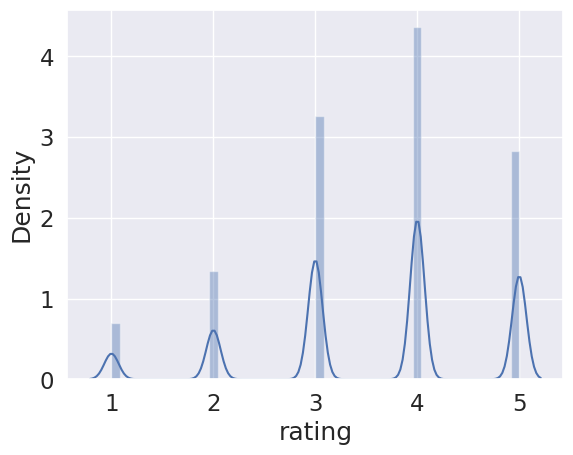

In [ ]:
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

By merging the dataframes into one we can get a clearer look with actual movie names and how they are rated vs. just having a movie_id.

In [ ]:
# Join all 3 files into one dataframe
dataset = pd.merge(pd.merge(movies, ratings),users)
# Display 20 movies with highest ratings
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(20)


,title,genres,rating
0,Toy Story (1995),Animation|Children's|Comedy,5
489283,American Beauty (1999),Comedy|Drama,5
489259,Election (1999),Comedy,5
489257,Matrix` The (1999),Action|Sci-Fi|Thriller,5
489256,Dead Ringers (1988),Drama|Thriller,5
489237,Rushmore (1998),Comedy,5
489236,Simple Plan` A (1998),Crime|Thriller,5
489226,Hands on a Hard Body (1996),Documentary,5
489224,Pleasantville (1998),Comedy,5
489212,Say Anything... (1989),Comedy|Drama|Romance,5


In [ ]:
dataset1 = dataset[dataset['genres'] != 'Comedy']
dataset1

,movie_id,title,genres,user_id,rating,ts,gender,age,occupation,zip
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067
...,...,...,...,...,...,...,...,...,...,...
1000204,3513,Rules of Engagement (2000),Drama|Thriller,5727,4,958489970,M,25,4,92843
1000205,3535,American Psycho (2000),Comedy|Horror|Thriller,5727,2,958489970,M,25,4,92843
1000206,3536,Keeping the Faith (2000),Comedy|Romance,5727,5,958489902,M,25,4,92843
1000207,3555,U-571 (2000),Action|Thriller,5727,3,958490699,M,25,4,92843


# Content-Based Filtering


Conten-Based Recommender Systems use the similarities between items being recommended to make predictions. The general idea behind it is that if a user likes a item, they will like items similar to it.

A good place to start with content filtering is to create a word cloud so that you can see some of the most common words that are used to describe the items in the data.

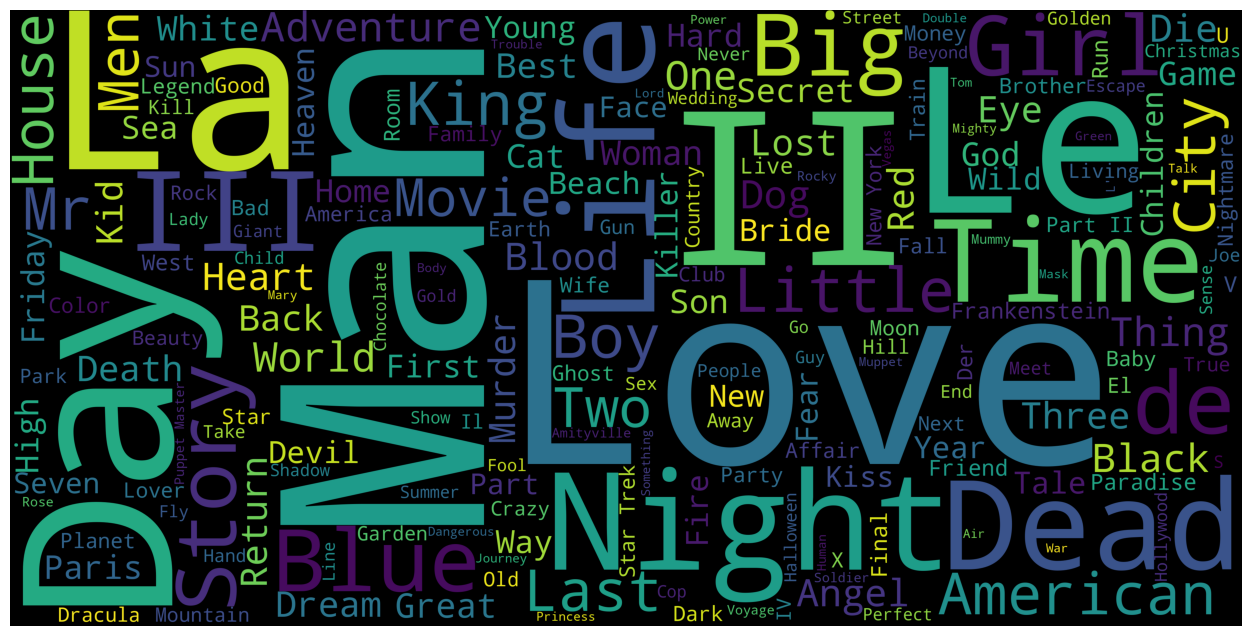

In [ ]:
# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

The following function is written to gather the frequency of the various genres that are included within the data. The following cell is similar to the wordcloud created above, but this time it is for the genre description of the movies.

In [ ]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census:
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):
        if type(census_keywords) == float and pd.isnull(census_keywords):
            continue
        for s in [s for s in census_keywords if s in census]:
            if pd.notnull(s):
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471]]

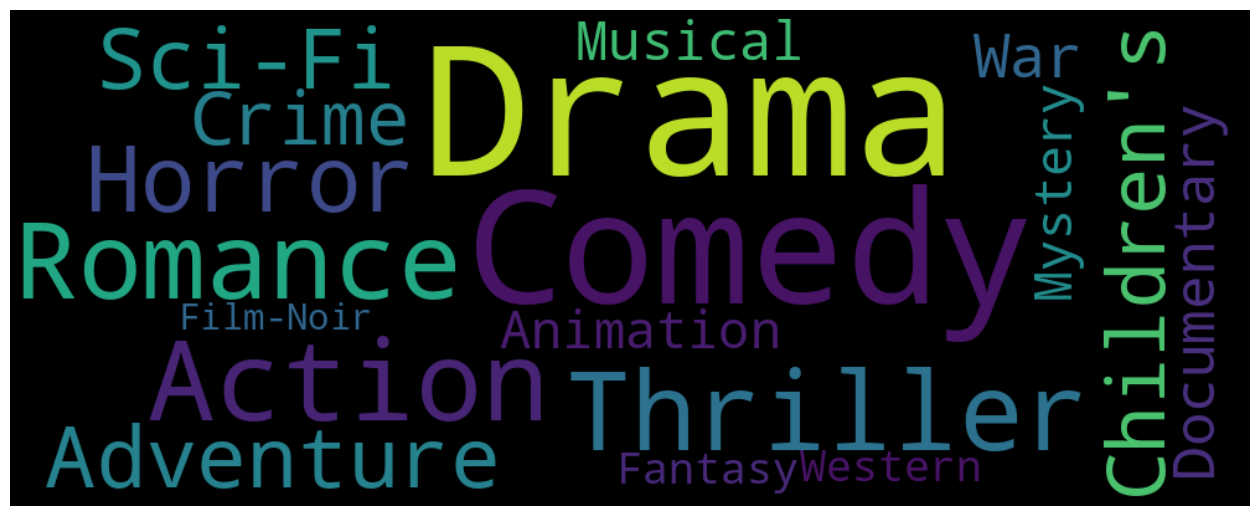

In [ ]:
# Define the dictionary used to produce the genre wordcloud
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='black')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

The Content-Based system that I will be compiling will be focused on recommended movies that are similar based on genre.

In [ ]:
# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

Because we need quantitative metrics to measure the performance of the system we have to break down the genres of our movies into feature vectors. We can do this using the TfidVectorizer library.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(3883, 127)

Because Content-Based makes predictions based of similarities it only makes sense that we would use similarity measures such as Cosine Similarity. We can do this using sklearn's linear_kernel library.

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 ],
       [0.14193614, 1.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 ],
       [0.1056164 , 0.        , 0.1719888 , 1.        ]])

Now that we have the similarity scores we can build a function to recommend movies based off their similarity to a given movie. That is what the next function aims to do.

In [ ]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
genre_recommendations('Good Will Hunting (1997)').head(20)

25                                        Othello (1995)
26                                   Now and Then (1995)
29     Shanghai Triad (Yao a yao yao dao waipo qiao) ...
30                                Dangerous Minds (1995)
35                               Dead Man Walking (1995)
39                       Cry` the Beloved Country (1995)
42                                    Restoration (1995)
52                                       Lamerica (1994)
54                                        Georgia (1995)
56                          Home for the Holidays (1995)
61                             Mr. Holland's Opus (1995)
66                                       Two Bits (1995)
77                            Crossing Guard` The (1995)
79          White Balloon` The (Badkonake Sefid ) (1995)
81                       Antonia's Line (Antonia) (1995)
82       Once Upon a Time... When We Were Colored (1995)
89                    Journey of August King` The (1995)
92                             

In [ ]:
genre_recommendations('Toy Story (1995)').head(20)

1050               Aladdin and the King of Thieves (1996)
2072                             American Tail` An (1986)
2073           American Tail: Fievel Goes West` An (1991)
2285                            Rugrats Movie` The (1998)
2286                                 Bug's Life` A (1998)
3045                                   Toy Story 2 (1999)
3542                                Saludos Amigos (1943)
3682                                   Chicken Run (2000)
3685       Adventures of Rocky and Bullwinkle` The (2000)
236                                 Goofy Movie` A (1995)
12                                           Balto (1995)
241                               Gumby: The Movie (1995)
310                             Swan Princess` The (1994)
592                                      Pinocchio (1940)
612                                Aristocats` The (1970)
700                               Oliver & Company (1988)
876     Land Before Time III: The Time of the Great Gi...
1010          

In [ ]:
genre_recommendations('Saving Private Ryan (1998)').head(20)

461            Heaven & Earth (1993)
1204        Full Metal Jacket (1987)
1214     Boat` The (Das Boot) (1981)
1222                    Glory (1989)
1545                G.I. Jane (1997)
1959      Saving Private Ryan (1998)
2358       Thin Red Line` The (1998)
2993         Longest Day` The (1962)
3559            Flying Tigers (1942)
3574    Fighting Seabees` The (1944)
3585    Guns of Navarone` The (1961)
3684             Patriot` The (2000)
40                Richard III (1995)
153            Beyond Rangoon (1995)
332         Walking Dead` The (1995)
523          Schindler's List (1993)
641        Courage Under Fire (1996)
967          Nothing Personal (1995)
979           Michael Collins (1996)
1074                  Platoon (1986)
Name: title, dtype: object

The drawbacks to using content-based filtering for making movie recommendations to users become apparent quickkly. The predictions are made solely off of how similarity between viewed items content and not how the user actually felt about the movie itself.

# Collaborative Filtering

In contrast to Content-Based Filtering, Collaborative bases it's recommendations off of past behavior, in this case, ratings of movies and similarity to ratings of other users. To expand, if user A highly rates a set of movies and user B rates that set of movies highly too, we could assume they share similar interests and a movie that user A likes, B would like as well.
This solves the big issue from Content-Based filtering.

Collaborative Filtering is the type of system that is most often used in recommender systems, due to the ability to pick on on latent features, meaning it is adaptible. There are 2 different types of Collaborative Filtering, Memory-Based and Model-Based. In this notebook I will be creating a Memorty-Based model.

## Memory-Based Collaborative Filtering


There are 2 primary types of memory-based algorithms, User-User and Item-Item.

<ul>
  <li> User-User: This algorithm finds users that are similar in regards to movie rating. While this method is effective it is slower and takes more space, so it struggles with large databases.
  </li>
  <li> Item-Item: Instead of find similar users, Item-Item looks to find similar movies to the ones a user has rated. This method is quicker and takes less space, but is not as effective as User-User.
  </li>
  <li> Both methods require the finding of a similarity matrix. This is done using one of the 3 primary similarity measures, Jaccard, Cosine and Pearson.
  </li>
</ul>

In [ ]:
# Fill NaN values in user_id and movie_id column with 0
ratings['user_id'] = ratings['user_id'].fillna(0)
ratings['movie_id'] = ratings['movie_id'].fillna(0)


# Replace NaN values in rating column with average of all values
ratings['rating'] = ratings['rating'].fillna(ratings['rating'].mean())

Removing the timestamp column from the dataframe as it is not needed for the purposes of this notebook.

In [ ]:
del ratings['ts']

We will randomly sample from the data. *Find the difference between using higher percentages of the data.

In [ ]:
# Randomly sample 1% of the ratings dataset
small_data = ratings.sample(frac=0.02)
# Check the sample info
print(small_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20004 entries, 813117 to 735422
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   20004 non-null  int64
 1   movie_id  20004 non-null  int64
 2   rating    20004 non-null  int64
dtypes: int64(3)
memory usage: 625.1 KB
None


Using the sklearn library we will split up our data into train and test sets.

In [ ]:
from sklearn.model_selection import train_test_split as cv

In [ ]:
train_data, test_data = cv(small_data, test_size=0.2)

In [ ]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data.to_numpy()
test_data_matrix = test_data.to_numpy()

# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(16003, 3)
(4001, 3)


Here the pairwise distance function is used to find the Pearson Correlation Coefficient.

##Evaluation


In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[ 1.          0.86486226  0.38215293 -0.34862015]
 [ 0.86486226  1.          0.79441592  0.16900681]
 [ 0.38215293  0.79441592  1.          0.7328987 ]
 [-0.34862015  0.16900681  0.7328987   1.        ]]


In [ ]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[ 1.         -0.01666623  0.01398657]
 [-0.01666623  1.         -0.05824508]
 [ 0.01398657 -0.05824508  1.        ]]


In [ ]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

# **Evaluating the System**


Root Mean Squared Error (RMSE) is a very popular metric that is ussed to evaluate the accuracy of Recommendation Systems.

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

Due to the high level of sparsity in this dataset I am not surprised by the high RMSE values for both the User and Item based models. This leads me to believe that the next type of model I should evaluate is one that can handle dimensionality reduction and data sparsity as those were very big issues that led to poor predictions accuracy for these.

In [ ]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 1435.2415187614702
Item-based CF RMSE: 1664.1347933225659


In [ ]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 696.7150803605888
Item-based CF RMSE: 145.79454006641316
